In [1]:
import ast
import re
import pandas as pd
import math
import numpy as np

Dane są w formacie jsonl. Konwertujemy je do json.

In [2]:
def read_data(path):
    with open(path, 'r') as f:
        lines = f.readlines() 
        
    json_formatted = '['
    for line in lines:
        json_formatted += line + ','
    json_formatted = json_formatted[:-1] + ']' 
    json_formatted = re.sub('null', 'None', json_formatted)
    return ast.literal_eval(json_formatted)

Tabela deliveries nie zawiera danych związanych z naszym zadaniem, w związku z czym nie będziemy jej dalej analizować.

In [3]:
drive = 'data/'

df_deliveries = pd.DataFrame(read_data(drive + 'deliveries.jsonl'))
df_products = pd.DataFrame(read_data(drive + 'products.jsonl'))
df_sessions = pd.DataFrame(read_data(drive + 'sessions.jsonl'))
df_users = pd.DataFrame(read_data(drive + 'users.jsonl'))

In [4]:
df_sessions['timestamp'] = pd.to_datetime(df_sessions['timestamp'])

In [5]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2020-03-26 22:22:04,102.0,1276.0,VIEW_PRODUCT,0,NaN
1,100001,2020-03-26 22:26:16,102.0,1276.0,BUY_PRODUCT,0,20001.0
2,100002,2020-01-02 01:45:52,102.0,1234.0,VIEW_PRODUCT,5,NaN
3,100002,2020-01-02 01:48:45,102.0,1233.0,VIEW_PRODUCT,5,NaN
4,100002,2020-01-02 01:52:29,102.0,1233.0,BUY_PRODUCT,5,20002.0


In [6]:
df_products.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99


In [7]:
import matplotlib.pyplot as plt

def plot_timeseries(df, column, n=10, df_labels=None, labels_column=None):
  cnt = df[column].value_counts()
  print(f'Unique values in "{column}": {len(cnt)}')
  idx = cnt.head(n).index
  plt.figure(figsize=(20, n))
  for i in range(n):
      plt.subplot(math.ceil(n / 5), 5, i+1)
      if df_labels is not None:
        plt.title(df_labels.loc[df_labels[column] == idx[i], labels_column].squeeze())
      else:
        plt.title(idx[i])
      temp = df[df[column] == idx[i]]
      temp.groupby([temp['timestamp'].dt.isocalendar().week])[column].count().plot()
  plt.show()


Przeprowadzamy analizę popularności produktów w zależności od tygodnia w roku, aby znaleźć potencjalne trendy.

Unique values in "product_id": 217


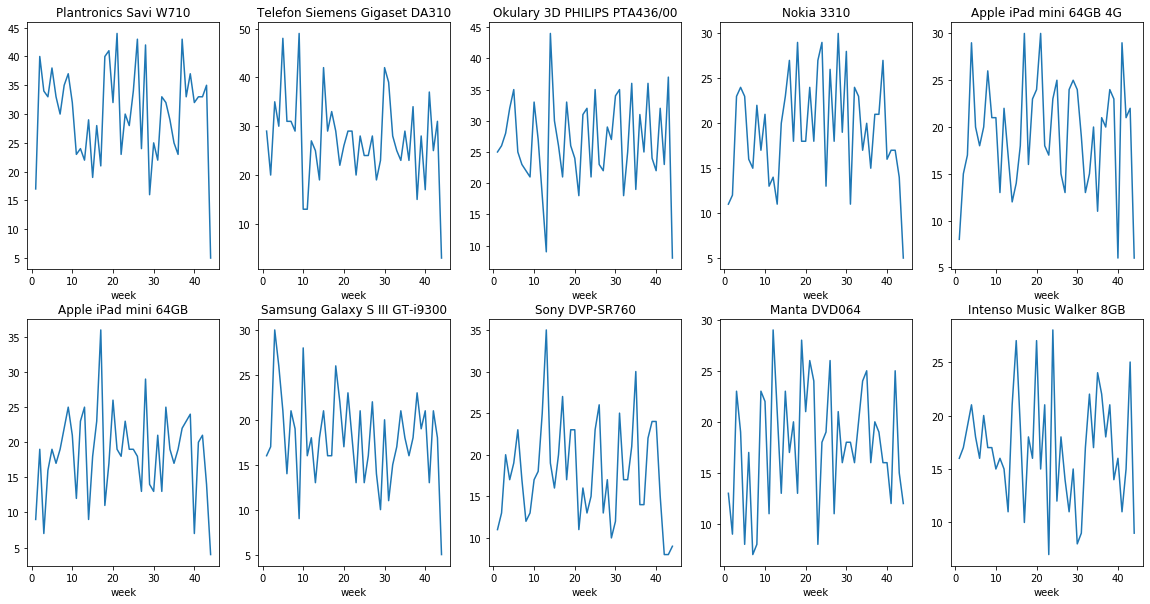

In [8]:
plot_timeseries(df_sessions, 'product_id', df_labels=df_products, labels_column='product_name', n=10)

Z analizy popularności produktów w zależności od daty doszliśmy do wniosku, że nie ma żadnej korelacji między tymi dwoma wartościami. Z wykresów obrazujących te zależności można wywnioskować, że popularność produktów zawsze oscyluje wokół pewnej stałej wartości.

In [9]:
def get_corrcoef_for_column(df, column, n=100):
    cnt = df[column].value_counts()
    idx = cnt.head(n).index
    weeks = range(44)
    
    correlations = []
    
    for i in range(n):
        temp = df[df[column] == idx[i]]
        try:
            # ignore if some data is missing
            array = [temp.groupby([temp['timestamp'].dt.isocalendar().week])[column].count(), weeks]
            correlation = np.corrcoef(array)[1,0]
            print(correlation)
            correlations.append(correlation)
        except:
            pass
        
    print("\nMaximum correlation found: ", max(correlations))
    print("Minimum correlation found: ", min(correlations))


In [10]:
get_corrcoef_for_column(df_sessions, 'product_id')

-0.07330211947725265
-0.23425244216863744
-0.009409859362104717
-0.006128829686010108
-0.020688149680378198
-0.0215874583936579
-0.24465175895227406
-0.10585999075688104
0.12812687147147808
-0.09527380929196172
0.06743008784599737
-0.020182903914779976
0.03483740502595009
-0.03764221715851983
-0.006211127985426151
-0.0906600667169857
0.031605884434522
0.08291182491104153
0.023050933105333477
-0.09528351192537605
-0.21622648860527863
-0.19926171938158227
-0.15704043875840984
-0.15857557143087955
-0.12736090886583099
0.05583560815063766
-0.09551484766488777
-0.08947140561427903
0.1804393113343129
0.007002187180664373
0.2606764717458011
-0.169656444000135
0.06195837038520493
-0.07844026107422877
-0.030273275663560827
-0.2735839922137598
-0.12439635923527735
-0.02372554898576334
0.29895508470380816
0.10825634578738992
0.19149365631169823
0.14302925321875096
0.20459528857142487
-0.17669127016136876
0.3170235267270701
0.029157354789558266
-0.02254792743169691
0.11024493157768184
0.0533189370

Wyliczenie współczynnika korelacji dla produktów utwierdziło nas we wniosku, że dane nie są skorelowane. Nawet w najbardziej skrajnych przypadkach te korelacje są na tyle delikatne i jest ich tak mało, że wynikają bardziej z 

In [11]:
df = df_products.set_index('product_id')
df_sessions = df_sessions.dropna(subset=['product_id'])
df_sessions.loc['product_id'] = df_sessions['product_id'].astype(int)
df = df_sessions.join(df, on='product_id')

Unique values in "category_path": 15


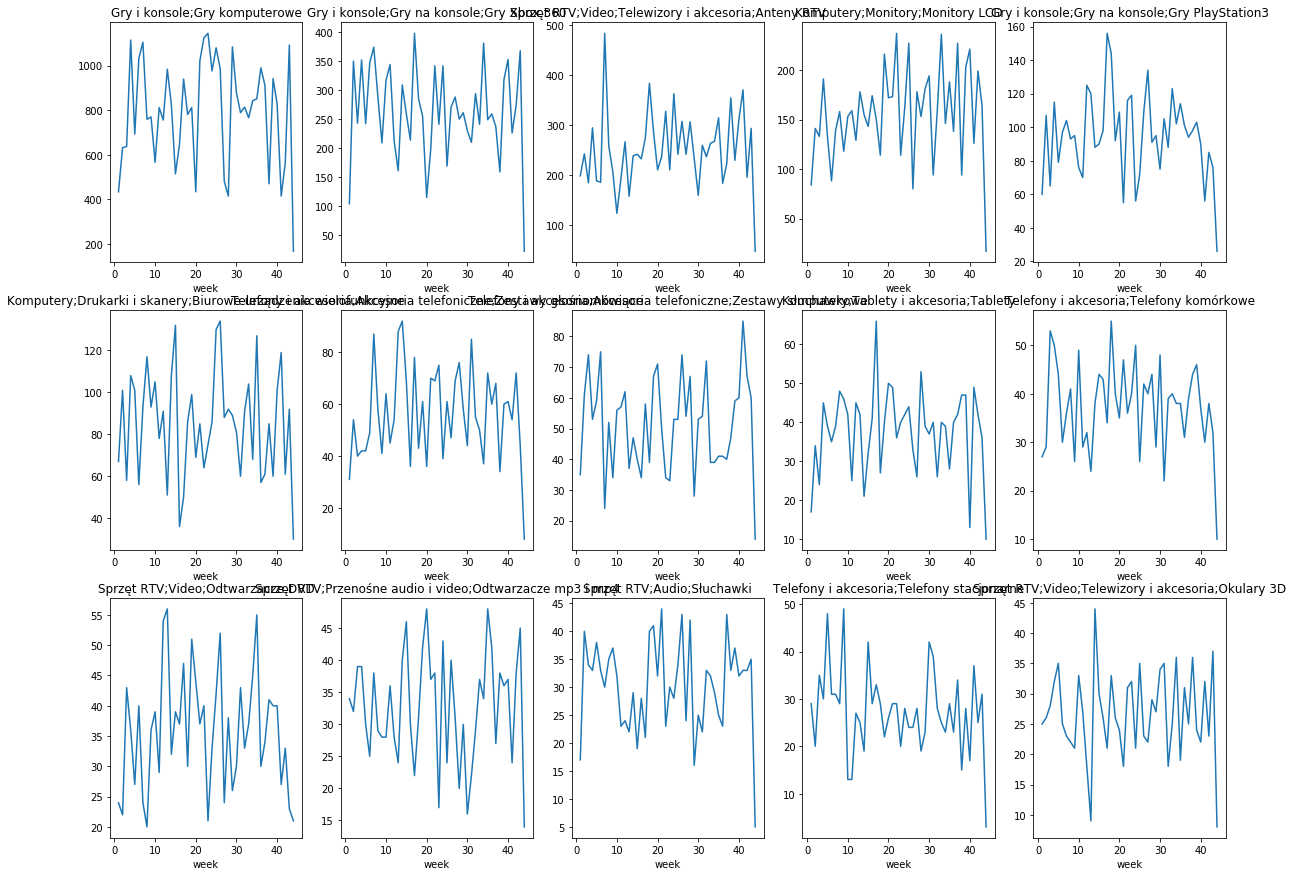

In [12]:
plot_timeseries(df, 'category_path', n=15)

In [13]:
len(df_products['category_path'].str.replace(';.*', '').unique())

4

Unique values in "category_path": 4


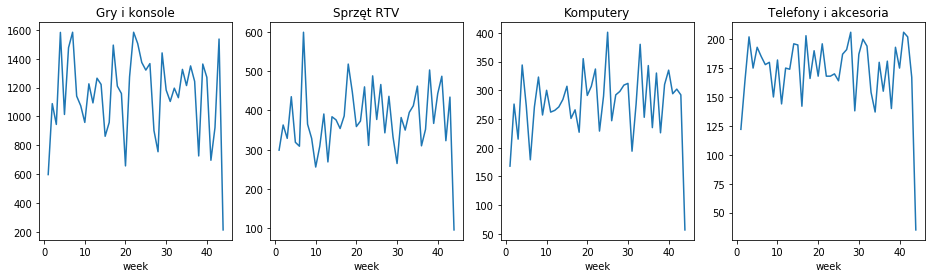

In [14]:
df_new = df.copy()
df_new['category_path'] = df_new['category_path'].str.replace(';.*', '')
plot_timeseries(df_new, 'category_path', n=4)

In [15]:
print("Korelacje dla wszystkich kategorii:")
get_corrcoef_for_column(df, 'category_path', 15)

print("\n\n\n")

print("Korelacje dla ogólnych kategorii:")
get_corrcoef_for_column(df_new, 'category_path', 4)

Korelacje dla wszystkich kategorii:
-0.06752249418364607
-0.11688722697302854
0.06753408311973741
0.16208040559815767
-0.12120093707588427
-0.09422266163180927
-0.013848724976338052
-0.008333601976885974
-0.02367556640643154
-0.13748899600190412
0.0103571828841387
-0.017950919145717302
-0.07330211947725265
-0.23425244216863744
-0.009409859362104717

Maximum correlation found:  0.16208040559815767
Minimum correlation found:  -0.23425244216863744




Korelacje dla ogólnych kategorii:
-0.09584741535120625
0.051317592124820184
0.08152645806193612
-0.1240313925359984

Maximum correlation found:  0.08152645806193612
Minimum correlation found:  -0.1240313925359984


Dla kategorii przeprowadziliśmy analogiczną analizę jak dla pojedynczych produktów. Ponownie nie ma znaczących korelacji. **W związku z tym, że nie ma trendów związanych z datą, to pominiemy ją w naszym modelu.**

<h1>Analiza zniżek</h1>

In [49]:
df = df_products.set_index('product_id')
df = df_sessions.join(df, on='product_id')

In [31]:
df.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,100001.0,2020-03-26 22:22:04,102.0,1276.0,VIEW_PRODUCT,0.0,NaN,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
1,100001.0,2020-03-26 22:26:16,102.0,1276.0,BUY_PRODUCT,0.0,20001.0,Apple iPad mini 64GB,Komputery;Tablety i akcesoria;Tablety,1816.97
2,100002.0,2020-01-02 01:45:52,102.0,1234.0,VIEW_PRODUCT,5.0,NaN,Sony DVP-SR760,Sprzęt RTV;Video;Odtwarzacze DVD,193.00
3,100002.0,2020-01-02 01:48:45,102.0,1233.0,VIEW_PRODUCT,5.0,NaN,Manta DVD064,Sprzęt RTV;Video;Odtwarzacze DVD,109.00
4,100002.0,2020-01-02 01:52:29,102.0,1233.0,BUY_PRODUCT,5.0,20002.0,Manta DVD064,Sprzęt RTV;Video;Odtwarzacze DVD,109.00


In [41]:
df.shape

(86988, 10)

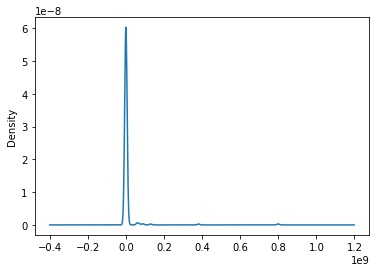

In [26]:
df['price'].plot.density()

Na cele analizy usuwamy błędne ceny

In [57]:
mask1 = df['price'] > 0
mask2 = df['price'] < 100_000

print('Cen ujemnych:', (~mask1).sum())
print('Cen za dużych:', (~mask2).sum())
print('W sumie usuwamy:', (~mask1).sum() + (~mask2).sum())

Cen ujemnych: 6210
Cen za dużych: 3584
W sumie usuwamy: 9794


In [58]:
df = df[mask1 & mask2]

In [59]:
df.shape

(77195, 10)

Text(0, 0.5, 'mean price')

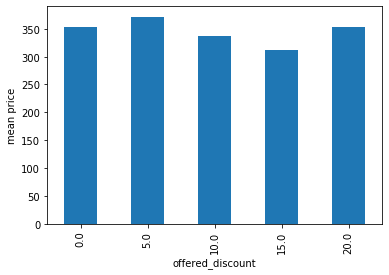

In [61]:
df.groupby('offered_discount')['price'].mean().plot(kind='bar')
plt.ylabel('mean price')

Jak widzimy cena produktu zakupionego przez klienta nie zależy od oferowanej mu zniżki. Nie jest więc tak, że klienci po dostaniu zniżki kupują droższe czy też tańsze produkty niż normalnie.

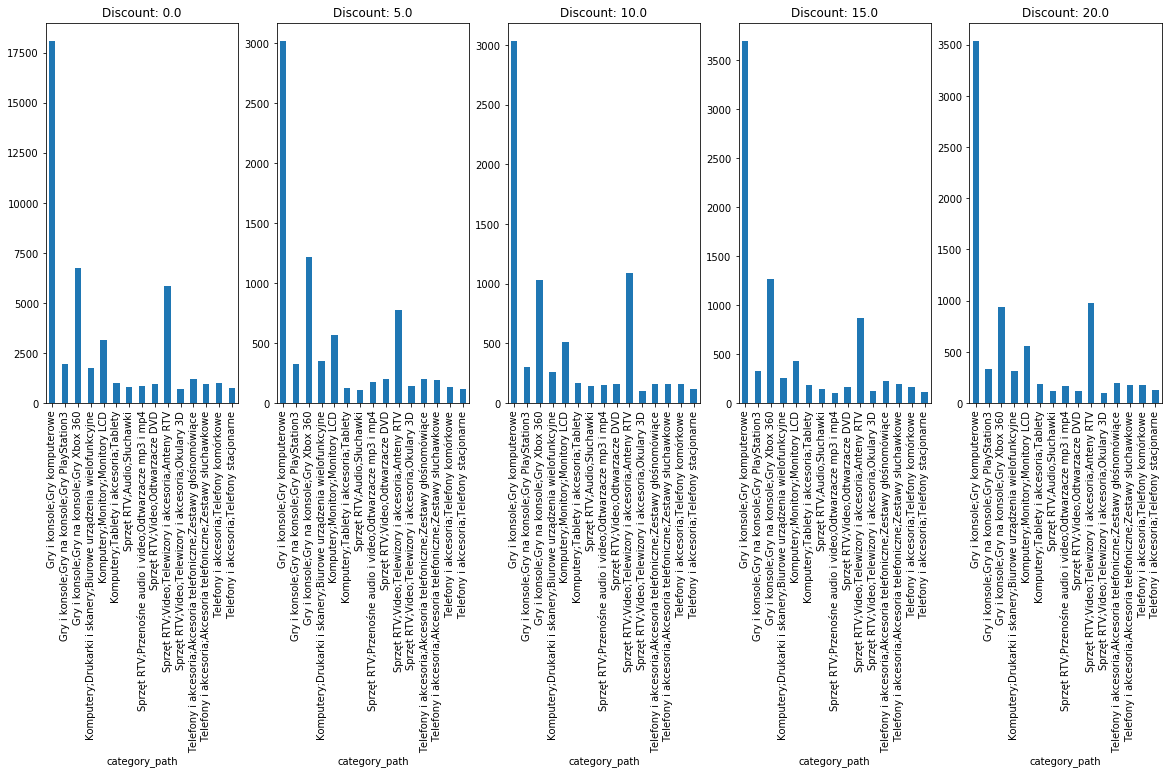

In [67]:
discounts = sorted(df['offered_discount'].unique())

plt.figure(figsize=(20, 7))
for i, discount in enumerate(discounts):
  plt.subplot(1, len(discounts), i+1)
  plt.title(f'Discount: {discount}')
  temp = df[df['offered_discount'] == discount]
  temp.groupby(['category_path'])['category_path'].count().plot(kind='bar')
plt.show()

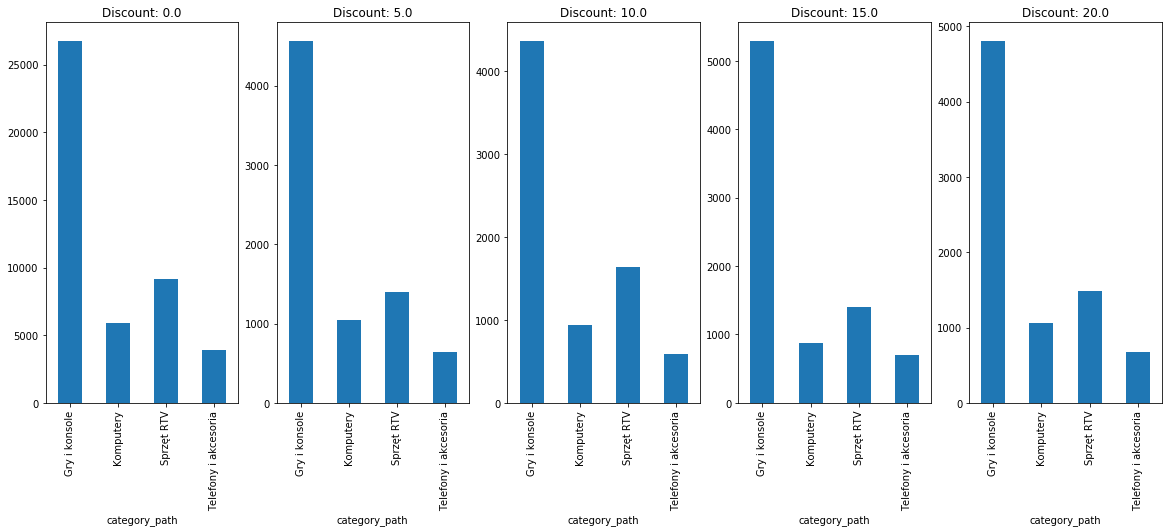

In [69]:
df['category_path'] = df['category_path'].str.replace(';.*', '')
plt.figure(figsize=(20, 7))
for i, discount in enumerate(discounts):
  plt.subplot(1, len(discounts), i+1)
  plt.title(f'Discount: {discount}')
  temp = df[df['offered_discount'] == discount]
  temp.groupby(['category_path'])['category_path'].count().plot(kind='bar')
plt.show()

Wygląda na to, że fakt posiadania zniżki nie wpływa też na to, produkty której kategorii klienci kupują. **Ostatecznie stwierdzamy, że zniżka jest nieistotna i nie będziemy jej używać w naszym modelu**

<h1>Analiza sesji</h1>

In [74]:
df = df_products.set_index('product_id')
df = df_sessions.join(df, on='product_id')
df.shape

(86988, 10)

In [75]:
df = df.dropna(subset=['session_id'])
df.shape

(86987, 10)

In [77]:
print('Liczba unikalnych sesji:', len(df['session_id'].unique()))

Liczba unikalnych sesji: 10706


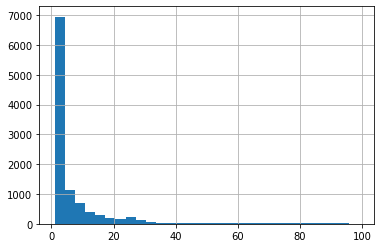

In [81]:
df.groupby('session_id')['session_id'].count().hist(bins=30)

In [85]:
cnt = df.groupby('session_id')['session_id'].count().value_counts()
del cnt[1]

In [86]:
cnt

2     3636
3     1567
4      578
5      534
6      343
      ... 
95       4
96       3
67       3
64       3
99       2
Name: session_id, Length: 97, dtype: int64